In [1]:
!rm -r /kaggle
!rm -r /input

rm: cannot remove '/kaggle/input': Device or resource busy
rm: cannot remove '/input': No such file or directory


In [2]:
!mkdir /input
!mkdir /kaggle
!mkdir /kaggle/working

mkdir: cannot create directory ‘/kaggle’: File exists


In [3]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00


In [4]:
import os
from google.colab import files

files.upload()

dataset = 'lfw-dataset'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/lfw-dataset

zip_file = f"{dataset}.zip"
destination_dir = f"../input/lfw-dataset"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle (1).json to kaggle (1).json
rm: cannot remove 'lfw-dataset': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
100% 112M/112M [00:00<00:00, 156MB/s] 
100% 112M/112M [00:00<00:00, 129MB/s]


In [5]:

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

In [6]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index", axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

844
880


<Axes: xlabel='name'>

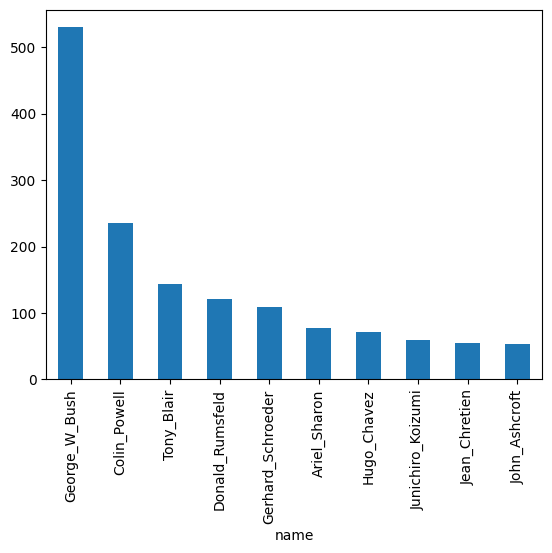

In [7]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [8]:
image_paths['name'].value_counts()[:10]

name
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64

In [9]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75),
                        image_paths[image_paths.name=="Hugo_Chavez"].sample(71),
                        image_paths[image_paths.name=="Junichiro_Koizumi"].sample(60),
                        image_paths[image_paths.name=="Jean_Chretien"].sample(55),
                        image_paths[image_paths.name=="John_Ashcroft"].sample(53)
                        ]
                       )

In [10]:
!pip install tensorflow-probability

In [11]:
import cv2
from sklearn.preprocessing import LabelEncoder

# Get the top 10 most frequent 'name' values
top_10_names = image_paths['name'].value_counts()[:10].index

# Filter the train and test DataFrames to only include rows where 'name' is in the top 10
lfw_train_top_10 = lfw_train[lfw_train['name'].isin(top_10_names)]
lfw_test_top_10 = lfw_test[lfw_test['name'].isin(top_10_names)]

# 1. Feature Extraction (without flattening)
def extract_features(image_paths):
    features = []
    for path in image_paths:
        img = cv2.imread(dataset_path + path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))  # Resize for consistency
        features.append(img)  # Append image without flattening
    return np.array(features)  # Convert to NumPy array

# Extract features for both train and test sets
X_train = extract_features(lfw_train_top_10['image_path'])
X_test = extract_features(lfw_test_top_10['image_path'])

# Reshape to add channel dimension (required for some DBN implementations)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)  # Add channel dimension
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)  # Add channel dimension

# 2. Label Encoding:
le = LabelEncoder()
y_train = le.fit_transform(lfw_train_top_10['name'])
y_test = le.transform(lfw_test_top_10['name'])  # Use transform, not fit_transform

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

In [14]:
rbm1 = BernoulliRBM(n_components=300, learning_rate=0.01, n_iter=20, verbose=1)
rbm2 = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=20, verbose=1)
rbm3 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=20, verbose=1)

# Initialize the logistic regression model
logistic = LogisticRegression(max_iter=1000)

# Create a pipeline that stacks the RBMs and then the logistic regression
dbn_pipeline = Pipeline(steps=[
    ('rbm1', rbm1),
    ('rbm2', clone(rbm1)),  # Clone the first RBM to reinitialize it with the same parameters but fresh state
    ('rbm3', clone(rbm2)),
    ('rbm4', clone(rbm3)),# Clone the second RBM
    ('logistic', logistic)
])

# Assuming X_train_scaled and y_train are already defined and preprocessed
# Train the DBN
dbn_pipeline.fit(X_train_scaled, y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -52638.18, time = 17.26s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -112007.75, time = 21.05s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -174114.59, time = 10.98s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -243388.53, time = 8.88s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -282550.80, time = 10.25s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -353955.78, time = 11.51s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -402894.58, time = 12.77s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -475698.61, time = 10.32s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -467310.62, time = 10.18s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -543607.95, time = 11.25s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -558733.57, time = 12.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -627508.85, time = 10.88s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -638795.63, time = 10.17s
[BernoulliRBM] Iteration 14, pseudo-

Pipeline(steps=[('rbm1',
                 BernoulliRBM(learning_rate=0.01, n_components=300, n_iter=20,
                              verbose=1)),
                ('rbm2',
                 BernoulliRBM(learning_rate=0.01, n_components=300, n_iter=20,
                              verbose=1)),
                ('rbm3',
                 BernoulliRBM(learning_rate=0.01, n_iter=20, verbose=1)),
                ('rbm4',
                 BernoulliRBM(learning_rate=0.01, n_components=128, n_iter=20,
                              verbose=1)),
                ('logistic', LogisticRegression(max_iter=1000))])

In [17]:
# Evaluate the model on the training set
dbn_train_score = dbn_pipeline.score(X_train_scaled, y_train)
print(f"Training Accuracy: {dbn_train_score*100}%")

# Evaluate the model on the test set
dbn_test_score = dbn_pipeline.score(X_test_scaled, y_test)
print(f"Validation Accuracy: {dbn_test_score*100}%")

Training Accuracy: 36.0%
Validation Accuracy: 38.07829181494662%


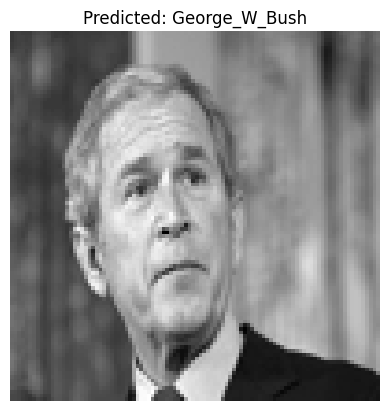

In [16]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

# Create upload button
upload = widgets.FileUpload(
    accept='.jpg',  # Accepted file extension
    multiple=False  # True to accept multiple files upload else False
)

# Display the upload button
display(upload)

# Define a function to handle the file upload
def on_file_upload(change):
    # Get the uploaded file
    uploaded_file = change['owner'].data[0]

    # Convert bytes to an image
    img = Image.open(io.BytesIO(uploaded_file))

    # Preprocess the image
    img = img.convert('L')  # Convert to grayscale
    img = img.resize((100, 100))  # Resize to match the model's expected input shape
    img_array = np.array(img)  # Convert to NumPy array
    img_array_flat = img_array.reshape(1, -1)  # Flatten the array

    # Predict the label
    label = dbn_pipeline.predict(img_array_flat)

    # Decode the label
    decoded_label = le.inverse_transform(label)

    # Clear the previous output
    clear_output()

    # Plot the image
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Predicted: {decoded_label[0]}")
    plt.axis('off')  # to hide the axis
    plt.show()

# Attach the function to the upload button
upload.observe(on_file_upload, names='data')